# Učitavanje train, valid, test skupova meta-podataka

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
import pandas as pd
trainDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/nih-chest-x-ray-train.csv', sep=',', index_col=0)
validDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/nih-chest-x-ray-valid.csv', sep=',', index_col=0)
testDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/nih-chest-x-ray-test.csv', sep=',', index_col=0)

In [4]:
trainDf.head()

,image_path,labels
0,./content/images/00002954_005.png,No Finding
1,./content/images/00017700_000.png,No Finding
2,./content/images/00012233_005.png,Pneumothorax
3,./content/images/00007354_010.png,Infiltration
4,./content/images/00008191_001.png,Atelectasis


In [5]:
validDf.head()

,image_path,labels
0,./content/images/00003308_002.png,No Finding
1,./content/images/00016621_000.png,Pleural_Thickening
2,./content/images/00028811_002.png,Effusion
3,./content/images/00017044_008.png,Consolidation
4,./content/images/00020703_023.png,No Finding


In [6]:
testDf.head()

,image_path,labels
0,./content/images/00000003_001.png,Hernia
1,./content/images/00000003_002.png,Hernia
2,./content/images/00000003_003.png,Hernia
3,./content/images/00000003_004.png,Hernia
4,./content/images/00000003_005.png,Hernia


# Pretprocesiranje skupa podataka

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [8]:
!unzip -qq /content/drive/MyDrive/images-nih-chest.zip

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGenerator = ImageDataGenerator(rescale=1./225).flow_from_dataframe(
    trainDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validate_filenames=True,   
)

validGenerator = ImageDataGenerator(rescale=1./225).flow_from_dataframe(
    validDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validate_filenames=True
)

Found 69219 validated image filenames belonging to 15 classes.
Found 17305 validated image filenames belonging to 15 classes.


# Kreiranje modela modifikacijom VGG-16 modela (eng. *Transfer Learning*) uz  fino podešavanje (eng. *Fine Tuning*)

In [46]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam

In [47]:
vgg16 = VGG16(include_top=True, weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
transferLayer = vgg16.get_layer('block5_pool')
transferLayer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [49]:
vgg16conv = Model(inputs=vgg16.input, outputs=transferLayer.output)

In [50]:
for layer in vgg16conv.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

True:	input_3
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [51]:
vgg16conv.trainable = False

In [52]:
for layer in vgg16conv.layers:
  trainable=('block4' in layer.name or 'block5' in layer.name)
  layer.trainable = trainable

In [53]:
for layer in vgg16conv.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	input_3
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [54]:
model = Sequential()
model.add(vgg16conv)
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(15, activation='softmax'))

In [55]:
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

False:	model_2
True:	flatten_4
True:	dense_9
True:	activation_6
True:	batch_normalization_6
True:	dense_10
True:	activation_7
True:	batch_normalization_7
True:	dense_11


# Kompilacija modela

In [56]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-0), 
    metrics = ['accuracy'],
)

# Treniranje modela

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointCB = ModelCheckpoint("vgg16-chest-x-ray.h5", save_best_only=True)

earlyStoppingCB = EarlyStopping(
    patience=10, restore_best_weights=True
)

In [58]:
history = model.fit(
      trainGenerator,
      epochs=20,
      steps_per_epoch=trainGenerator.samples // BATCH_SIZE,
      validation_data=validGenerator,
      validation_steps=validGenerator.samples // BATCH_SIZE,
      callbacks=[checkpointCB]
    )

Epoch 1/20
4326/4326 [==============================] - 405s 93ms/step - loss: 417.5168 - accuracy: 0.3878 - val_loss: 23829346.0000 - val_accuracy: 0.2425
Epoch 2/20
4326/4326 [==============================] - 403s 93ms/step - loss: 387.7346 - accuracy: 0.4085 - val_loss: 8343036.5000 - val_accuracy: 0.5188
Epoch 3/20
4326/4326 [==============================] - 403s 93ms/step - loss: 357.6773 - accuracy: 0.4075 - val_loss: 12022675.0000 - val_accuracy: 0.5143
Epoch 4/20
4326/4326 [==============================] - 404s 93ms/step - loss: 283.5476 - accuracy: 0.4077 - val_loss: 39760648.0000 - val_accuracy: 0.3751
Epoch 5/20
4326/4326 [==============================] - 404s 93ms/step - loss: 370.3920 - accuracy: 0.4137 - val_loss: 191942720.0000 - val_accuracy: 0.4447
Epoch 6/20
4326/4326 [==============================] - 403s 93ms/step - loss: 270.7860 - accuracy: 0.4124 - val_loss: 2067954304.0000 - val_accuracy: 0.2564
Epoch 7/20
4326/4326 [==============================] - 402s 9

# Rezultati treniranja

In [83]:
import matplotlib.pyplot as plt

def plotHistory(history):
  fig, axs = plt.subplots(2, figsize=(20,10))
  axs[0].plot(history.history["accuracy"])
  axs[0].plot(history.history['val_accuracy'])
  axs[1].plot(history.history["loss"])
  axs[1].plot(history.history['val_loss'])
  axs[0].set_title("model accuracy")
  axs[0].set(xlabel='epoch', ylabel='acc')
  axs[1].set(xlabel='epoch', ylabel='loss')
  axs[0].legend(["Accuracy","Validation Accuracy"])
  axs[1].legend(["Loss","Validation Loss"])
  plt.show()

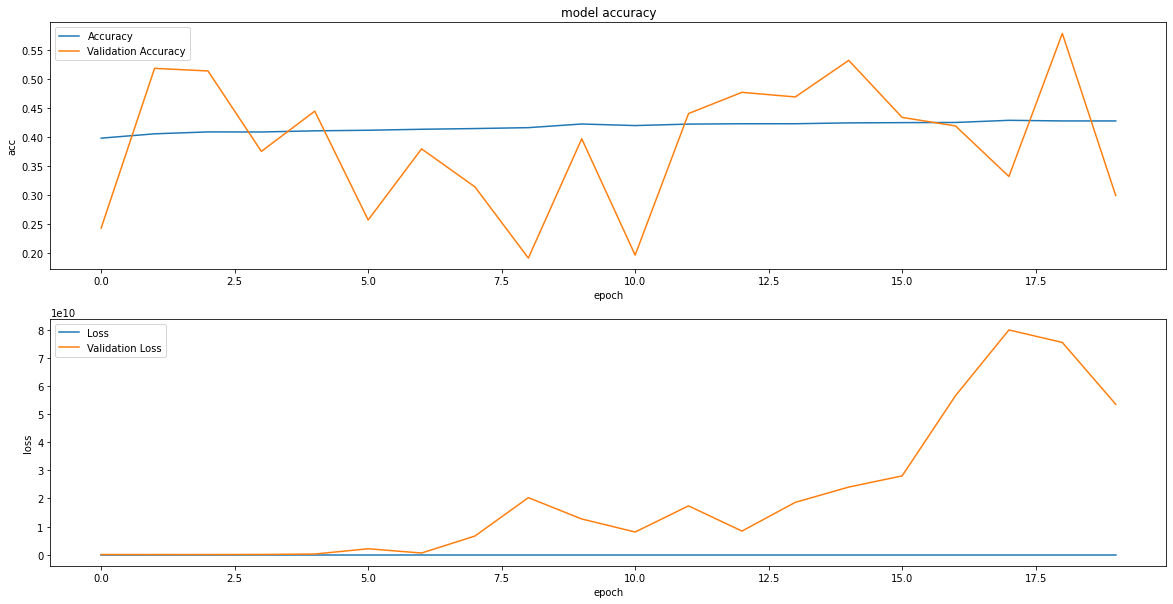

In [84]:
plotHistory(history)

# Rezultati evaluacije

In [61]:
testDataGen = ImageDataGenerator(
    rescale=1./255,
)

testGenerator = testDataGen.flow_from_dataframe(
    testDf,
    x_col="image_path",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    validate_filenames=True
)

Found 25596 validated image filenames belonging to 15 classes.


In [62]:
results = model.evaluate(testGenerator, steps=testGenerator.samples // BATCH_SIZE)

1599/1599 [==============================] - 114s 71ms/step - loss: 38669615104.0000 - accuracy: 0.1594


In [63]:
print("Accuracy on test set: {0:.2%}".format(results[1]))

Accuracy on test set: 15.94%


# Dodatak: Balansiranje klasa
Pokušano je balansiranje klasa automatskim dodeljivanjem težina manje zastupljenim klasama, međutim, to nije pružilo dobre rezultate. Trebalo bi pokušati sa drugim metodama balansiranja.

In [64]:
# from sklearn.utils import class_weight
# import numpy as np

# class_weights = class_weight.compute_class_weight(
#                'balanced',
#                 np.unique(trainGenerator.classes), 
#                 trainGenerator.classes)

# class_weights = dict(enumerate(class_weights))

# Dodatak: Neuspešan *custom* model

Isprobano je nekoliko nezavisnih modela koji nisu davali dobre rezultate tokom treniranja u 100 epoha. Jedan od modela je prikazan u nastavku.

In [65]:
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Conv2D(64, (3, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Conv2D(128, (3, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Conv2D(128, (3, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Conv2D(256, (3, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Conv2D(256, (3, 3), strides=(1,1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# model.add(Flatten())

# model.add(Dense(1024))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(1024))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(15))
# model.add(Activation('softmax'))

# Dodatak: Treniranje modela na TPU

Google Colab je okruženje koje pruža hardver različitih performansi za rad. Naredni kod koji je dat pod komentarima je pokušaj konfigurisanja skupa podataka, kao i celokupnog okruženja za rad sa TPU hardverom, međutim, zbog korišćenja *ImageDataGenerator* klase, generatori su morali da budu "obavijeni" u *tensorflow* Dataset, ali je ovaj pokušaj bio neuspešan. Uvidom u *issue* sekciju Tensorflow GitHub repozitorijuma, kao i nekoliko odgovora pronađenih na StackOverflow stranici, utvrđeno je da postoji *bug* koji se javlja mnogim korisnicima i da do datuma (1.2.2021.) izrade ovog rada nije uspešno rešen. ([1](https://github.com/tensorflow/tensorflow/issues/34346), [2](https://stackoverflow.com/questions/52636127/how-to-use-keras-generator-with-tf-data-api), [**3**](https://stackoverflow.com/questions/63846264/how-to-use-tpu-on-kaggle-colab-with-imagedatagenerator))

In [66]:
# Wrapping the keras generator
# trainDS = tf.data.Dataset.from_generator(
#     lambda: trainGenerator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes = ([BATCH_SIZE,224,224,3],
#                      [BATCH_SIZE,15])
#     )

# validDS = tf.data.Dataset.from_generator(
#     lambda: validGenerator,
#     output_types=(tf.float32, tf.float32),
#     output_shapes = ([BATCH_SIZE,224,224,3],
#                      [BATCH_SIZE,15])
#     )

In [67]:
# import re
# import os
# import random
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [68]:
# with strategy.scope():
#   model = create_model()
#       loss = 'categorical_crossentropy', 
#       optimizer = Adam(learning_rate=0.0001), 
#       metrics = ['accuracy'],
#       steps_per_execution = 50,
#   )